# GMeans Test

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
import inspect
import os
import sys
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
cmd_folder = os.path.realpath(os.path.join(cmd_folder, ".."))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

import numpy as np
import seaborn as snb

snb.set_style('darkgrid')
snb.set_palette("Paired", 15, .75)
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.stats import anderson

In [2]:
from matplotlib import pyplot as plt
import time
import logging
fig_size=(10, 10)
from typing import Union

In [3]:
class GMeans():
    """
    Implementation of GMeans Clustering to be used with ISAC
    """
    def __init__(self, minimum_samples_per_cluster: int=2, n_init: int=10, significance: int=4,
                 restarts: int=10, seed: int=12345):

        self.minimum_samples_per_cluster = minimum_samples_per_cluster
        self.n_init = n_init
        self.significance = significance
        self.restarts = restarts
        self.random_state = np.random.RandomState(seed)
        self.KMobject = None  # type: Union[KMeans, MiniBatchKMeans, None]
        self._BestKMobject = None  # type: Union[KMeans, MiniBatchKMeans, None]
        self.inertia = np.float('inf')
        self.logger = logging.getLogger('GMeans')
        self.partitions=list()

    def partition(self, X, use_mini_batch:bool=False, *args, **kwargs):
        inertia_ = np.float('inf')
        for _ in range(self.restarts):
            self.partitions = []
            self.logger.info('Round %d%s' % ((_ + 1), '#'*100))
            self._fit_recursive(X, use_mini_batch=use_mini_batch)
            if self.KMobject.inertia_ < inertia_:
                inertia_ = self.KMobject.inertia_
                self._BestKMobject = self.KMobject
        self.KMobject = self._BestKMobject
        return self.KMobject.predict(X)
    
    
    def _fit_recursive(self, X: np.ndarray, label: int=0, use_mini_batch: bool=False,
                       depth: int=0, parent_center: Union[np.ndarray, None]=None):
        """
        Implementation of the algorithm to learn the correct k for KMeans clustering presented in
        'Hamerly, Greg, and Charles Elkan. "Learning the k in k-means." NIPS. Vol. 3. 2003.'
        and used in
        'Kadioglu, Serdar, et al. "ISAC-Instance-Specific Algorithm Configuration." ECAI. Vol. 215. 2010.'
        :param X: Feature Array
        :param use_mini_batch: bool to determine which sklearn KMeans variant to use
        :param parent_center: start point
        :param: depth: recursion depth
        """
        self.logger.debug('%sAt depth %d' % (' ' * 2 * depth, depth))
        KM = MiniBatchKMeans if use_mini_batch else KMeans
        # First treat everything as beloning to one large partition
        if depth == 0:
            km_object = KM(n_clusters=1, n_init=self.n_init, random_state=self.random_state)
            km_object.fit(X)
            self._fit_recursive(X, use_mini_batch=use_mini_batch,
                                depth=depth+1, parent_center=km_object.cluster_centers_)
            self.KMobject = KM(n_clusters=len(self.partitions), n_init=self.n_init, init=np.array(self.partitions),
                               random_state=self.random_state)
            self.KMobject.fit(X)
        else:
            if X.shape[0] <= self.minimum_samples_per_cluster:
                self.logger.error(parent_center)
                self.logger.error(self.partitions)
                self.logger.warning('TOOO SMALLLLLLL')
                raise Exception('Too small to even start at depth %d' % depth)
                return None
            else:
                km_object = KM(n_clusters=2, n_init=self.n_init, random_state=self.random_state)
                km_object.fit(X)
                # test the split for its gaussianity by ...
                centroid_0, centroid_1 = km_object.cluster_centers_
                diff = centroid_0 - centroid_1
                # ... projecting it onto a line
                projected_X = np.inner(diff, X) / np.linalg.norm(diff, ord=2)
                mean, std = np.mean(projected_X), np.std(projected_X)
                projected_X = (projected_X - mean) / std  # and making it zero mean and std 1
                statistic, critical, _ = anderson(projected_X)  # and then using the anderson-darling test
                left_indices = km_object.labels_ == 0
                right_indices = km_object.labels_ == 1

                if statistic >= critical[self.significance]:  # accept the split
                    if sum(left_indices) <= self.minimum_samples_per_cluster or \
                                    sum(right_indices) <= self.minimum_samples_per_cluster:
                        self.partitions.append(parent_center)
                        self.logger.error('TOOO SMAAALLLLL')
                        self.logger.info('%sRejecting Split for label %d' % (' ' * 2 * depth, label))
                        self.logger.info('%s-> new #clusters %d' % (' ' * 2 * depth, len(self.partitions)))
                    else:
                        self._fit_recursive(X[left_indices], 0, use_mini_batch=use_mini_batch, depth=depth+1,
                                            parent_center=km_object.cluster_centers_[0])
                        self._fit_recursive(X[right_indices], 1, use_mini_batch=use_mini_batch, depth=depth+1,
                                            parent_center=km_object.cluster_centers_[1])
                        self.logger.info('%sAccepting Split for label %d' % (' ' * 2 * depth, label))
                        self.logger.info('%s-> new #clusters %d' % (' ' * 2 * depth, len(self.partitions)))
                else:
                    self.partitions.append(parent_center)
                    self.logger.info('%sRejecting Split for label %d' % (' ' * 2 * depth, label))
                    self.logger.info('%s-> new #clusters %d' % (' ' * 2 * depth, len(self.partitions)))

In [20]:
n_clusters = 6
X, labels_true = make_blobs(n_samples=6000, centers=n_clusters, cluster_std=1.5)

In [26]:
logging.basicConfig(level=logging.INFO)
gm = GMeans(n_init=10, minimum_samples_per_cluster=500, restarts=3)
preds = gm.partition(X, use_minibatch=False, use_mini_batch=False)


INFO:GMeans:Round 1####################################################################################################
ERROR:GMeans:TOOO SMAAALLLLL
INFO:GMeans:      Rejecting Split for label 0
INFO:GMeans:      -> new #clusters 1
ERROR:GMeans:TOOO SMAAALLLLL
INFO:GMeans:        Rejecting Split for label 0
INFO:GMeans:        -> new #clusters 2
INFO:GMeans:        Rejecting Split for label 1
INFO:GMeans:        -> new #clusters 3
INFO:GMeans:      Accepting Split for label 1
INFO:GMeans:      -> new #clusters 3
INFO:GMeans:    Accepting Split for label 0
INFO:GMeans:    -> new #clusters 3
INFO:GMeans:        Rejecting Split for label 0
INFO:GMeans:        -> new #clusters 4
INFO:GMeans:        Rejecting Split for label 1
INFO:GMeans:        -> new #clusters 5
INFO:GMeans:      Accepting Split for label 0
INFO:GMeans:      -> new #clusters 5
ERROR:GMeans:TOOO SMAAALLLLL
INFO:GMeans:      Rejecting Split for label 1
INFO:GMeans:      -> new #clusters 6
INFO:GMeans:    Accepting Split fo

In [12]:
order = [0, 1, 2, 3, 4, 5]
km = KMeans(n_clusters=8)
km.fit(X)
prods = km.predict(X)

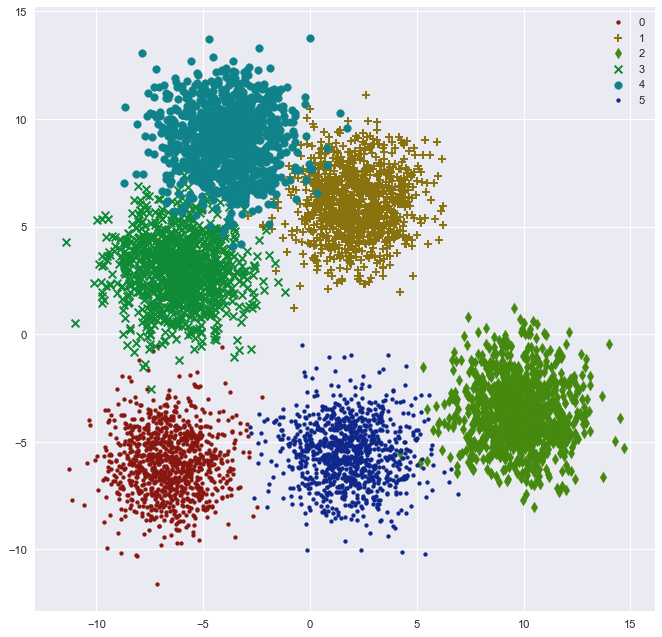

In [21]:
%matplotlib inline
np.random.seed(int(time.time()))
plt.close('all')
fig=plt.figure(figsize=fig_size, dpi= 80)
alpha=1.1
markers=['.', '+', 'd', 'x', 'o']
count = -1

pallet = snb.hls_palette(max(n_clusters, max(max(preds) + 1, max(prods) + 1)), l=.3, s=.8)
for i in range(n_clusters):
    if i % 6 == 0:
        count+=1
        alpha -= 0.1
        alpha = max(alpha, 0.1)
    marker = markers[i%len(markers)]
    plt.scatter(X[labels_true==i, 0], X[labels_true==i, 1], label=i, marker=marker, alpha=alpha, color=pallet[i])
plt.legend()

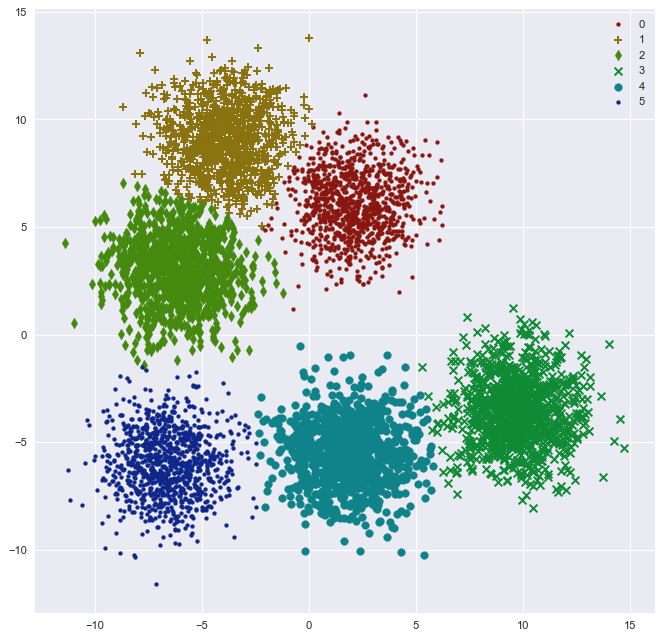

In [27]:
plt.close('all')
fig=plt.figure(figsize=fig_size, dpi= 80)
idcs = []
all_ = 0
alpha=1.1
markers=['.', '+', 'd', 'x', 'o']
count = -1
for i in range(max(preds) + 1):
    if i % 6 == 0:
        count+=1
        alpha -= 0.1
        alpha = max(alpha, 0.1)
    marker = markers[i % len(markers)]
    plt.scatter(X[preds == i, 0], X[preds == i, 1], label=i, alpha=alpha, marker=marker, color=pallet[i])
    idcs.append(preds==i)
    logging.debug('Points in cluster %d: %d' % (i, len(preds[preds==i])))
    all_ += len(preds[preds==i])
idcs = np.array(idcs)
idc_mean = np.mean(idcs.T, axis=1)
logging.debug('#not covered: %d' % sum(idc_mean == 0))
#plt.scatter(X[idc_mean == 0, 0], X[idc_mean == 0, 1], label='not_found', alpha=0.5, color='k')
plt.legend()

6
8


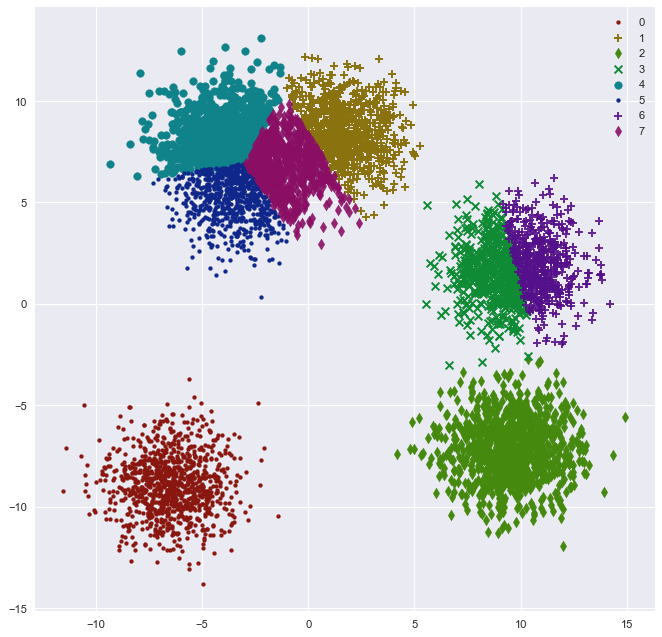

In [15]:
plt.close('all')
fig=plt.figure(figsize=fig_size, dpi= 80)
idcs = []
all_ = 0
alpha=1.1
markers=['.', '+', 'd', 'x', 'o']
count = -1
tmp_pallet=np.array(pallet)
print(len(np.array(pallet)[order]))
print(max(prods) + 1)
for i in range(max(prods) + 1):
    if i % 6 == 0:
        count+=1
        alpha -= 0.1
        alpha = max(alpha, 0.1)
    marker = markers[i % len(markers)]
    plt.scatter(X[prods == i, 0], X[prods == i, 1], label=i, alpha=alpha, marker=marker, color=tmp_pallet[i])
    idcs.append(prods==i)
    logging.debug('Points in cluster %d: %d' % (i, len(prods[prods==i])))
    all_ += len(prods[prods==i])
idcs = np.array(idcs)
idc_mean = np.mean(idcs.T, axis=1)
logging.debug('#not covered: %d' % sum(idc_mean == 0))
#plt.scatter(X[idc_mean == 0, 0], X[idc_mean == 0, 1], label='not_found', alpha=0.5, color='k')
plt.legend()